<a href="https://colab.research.google.com/github/Aryanp018/NYC_Urban_analytics/blob/main/NYC_Urban_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the PostgreSQL adapter
!pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.6 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
import psycopg2

# 1. Retrieve the secure connection string
try:
    CONN_STRING = userdata.get('NEON_DB_CONNECTION_STRING')
except KeyError:
    print("Error: Please set the 'NEON_DB_CONNECTION_STRING' in Colab Secrets!")

# 2. Connect to Neon
def test_connection():
    try:
        conn = psycopg2.connect(CONN_STRING)
        cur = conn.cursor()

        # Run a simple query to check version
        cur.execute("SELECT version();")
        db_version = cur.fetchone()

        print("Success! Connected to:", db_version[0])

        cur.close()
        conn.close()
    except Exception as e:
        print("Connection failed:", e)

test_connection()

SecretNotFoundError: Secret NEON_DB_CONNECTION_STRING does not exist.

In [ ]:
# Define the SQL for creating tables
create_tables_sql = """
-- 1. Create the Demographics Table (Parent Table)
CREATE TABLE IF NOT EXISTS dim_nyc_demographics (
    zip_code TEXT PRIMARY KEY,
    total_population INTEGER,
    median_income NUMERIC,
    borough TEXT
);

-- 2. Create the 311 Service Requests Table
CREATE TABLE IF NOT EXISTS fact_311_requests (
    unique_key TEXT PRIMARY KEY,
    created_date TIMESTAMP,
    complaint_type TEXT,
    incident_zip TEXT,
    status TEXT,
    -- Define the Foreign Key relationship
    CONSTRAINT fk_zip_311
        FOREIGN KEY(incident_zip)
        REFERENCES dim_nyc_demographics(zip_code)
        ON DELETE SET NULL
);

-- 3. Create the Real Estate Sales Table
CREATE TABLE IF NOT EXISTS fact_property_sales (
    sale_id SERIAL PRIMARY KEY,
    neighborhood TEXT,
    building_class_category TEXT,
    zip_code TEXT,
    sale_price NUMERIC,
    sale_date DATE,
    -- Define the Foreign Key relationship
    CONSTRAINT fk_zip_sales
        FOREIGN KEY(zip_code)
        REFERENCES dim_nyc_demographics(zip_code)
        ON DELETE SET NULL
);
"""

# Execute the SQL
try:
    conn = psycopg2.connect(CONN_STRING)
    cur = conn.cursor()
    cur.execute(create_tables_sql)
    conn.commit()
    print("All 3 Tables created successfully!")

    # Verify they exist
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()
    print("Current Tables in Database:", tables)

    cur.close()
    conn.close()
except Exception as e:
    print("Error creating tables:", e)

Error creating tables: name 'CONN_STRING' is not defined


In [ ]:
import os
from google.colab import files

# 1. Upload the kaggle.json file
files.upload()

# 2. Move it to the correct folder so the tools can find it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle configured successfully!")

In [ ]:
import psycopg2
import pandas as pd
import io
import os
from google.colab import userdata

# Get connection string
try:
    CONN_STRING = userdata.get('NEON_DB_CONNECTION_STRING')
except KeyError:
    print("Error: NEON_DB_CONNECTION_STRING not found in Secrets.")

def fast_upload_to_neon(df, table_name):
    """
    Uploads a Pandas DataFrame to Neon using COPY.
    """
    # Create in-memory buffer
    csv_buffer = io.StringIO()

    # Write dataframe to buffer as CSV (no header, no index)
    df.to_csv(csv_buffer, index=False, header=False, sep=',')
    csv_buffer.seek(0)

    try:
        conn = psycopg2.connect(CONN_STRING)
        cur = conn.cursor()

        # COPY command
        copy_sql = f"COPY {table_name} FROM STDIN WITH (FORMAT CSV, DELIMITER ',')"
        cur.copy_expert(copy_sql, csv_buffer)

        conn.commit()
        print(f"Uploaded {len(df)} rows to {table_name}")
        cur.close()
        conn.close()
    except Exception as e:
        print(f"Upload failed for {table_name}: {e}")

In [ ]:
import os

# 1. Check for API Key
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("kaggle.json not found! Please upload it again.")
    from google.colab import files
    files.upload() # Upload your kaggle.json if prompted
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("Kaggle API key found.")

# 2. Download Datasets
print("\n--- Downloading Datasets ---")
!kaggle datasets download -d new-york-city/ny-311-service-requests
!kaggle datasets download -d new-york-city/nyc-property-sales
!kaggle datasets download -d muonneutrino/new-york-city-census-data

# 3. Unzip Datasets
print("\n--- Unzipping ---")
!unzip -o ny-311-service-requests.zip
!unzip -o nyc-property-sales.zip
!unzip -o new-york-city-census-data.zip

# 4. Verify Files
print("\n--- Verifying Files ---")
expected_files = ['nyc-rolling-sales.csv', '311_Service_Requests.csv']
files_present = [f for f in os.listdir('.') if f.endswith('.csv')]

print(f"Files found: {files_present}")

if any('rolling-sales' in f for f in files_present):
    print("SUCCESS: Files are ready.")
else:
    print("ERROR: Files still missing.")

✅ Kaggle API key found.

--- Downloading Datasets ---
Dataset URL: https://www.kaggle.com/datasets/new-york-city/ny-311-service-requests
License(s): other
 99% 3.21G/3.24G [00:10<00:00, 598MB/s]
100% 3.24G/3.24G [00:10<00:00, 337MB/s]
Dataset URL: https://www.kaggle.com/datasets/new-york-city/nyc-property-sales
License(s): CC0-1.0
  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 927MB/s]
Dataset URL: https://www.kaggle.com/datasets/muonneutrino/new-york-city-census-data
License(s): CC0-1.0
  0% 0.00/343k [00:00<?, ?B/s]
100% 343k/343k [00:00<00:00, 1.03GB/s]

--- Unzipping ---
Archive:  ny-311-service-requests.zip
  inflating: 311-service-requests-from-2010-to-present.csv  
  inflating: 311-web-content-services.csv  
  inflating: 311_SR_Data_Dictionary_2018.xlsx  
  inflating: socrata_metadata_311-service-requests-from-2010-to-present.json  
  inflating: socrata_metadata_311-web-content-services.json  
Archive:  nyc-property-sales.zip
  inflating: nyc-rolling-sales.csv   

In [ ]:
import pandas as pd
# Ensure the upload function is defined
# (If you restarted Colab, you might need to re-run the 'fast_upload_to_neon' function definition block from earlier)

print("Building Demographics table...")

# 1. Load Sales Data
df_sales_raw = pd.read_csv('nyc-rolling-sales.csv')

# 2. Extract Unique Zip Codes to create our "Demographics" master list
unique_zips = df_sales_raw[['ZIP CODE', 'BOROUGH']].drop_duplicates()
unique_zips.columns = ['zip_code', 'borough']

# 3. Clean Zip Codes (Remove '.0' and '0')
unique_zips['zip_code'] = unique_zips['zip_code'].astype(str).str.replace('.0', '', regex=False)
unique_zips = unique_zips[unique_zips['zip_code'] != '0']

# 4. Add Placeholders (0) for Population/Income to satisfy the table structure
unique_zips['total_population'] = 0
unique_zips['median_income'] = 0

# 5. Prepare final dataframe
df_upload_demo = unique_zips[['zip_code', 'total_population', 'median_income', 'borough']]
df_upload_demo = df_upload_demo.drop_duplicates(subset=['zip_code'])

# 6. Upload
fast_upload_to_neon(df_upload_demo, 'dim_nyc_demographics')

Building Demographics table...
Upload failed for dim_nyc_demographics: duplicate key value violates unique constraint "dim_nyc_demographics_pkey"
DETAIL:  Key (zip_code)=(10009) already exists.
CONTEXT:  COPY dim_nyc_demographics, line 1



In [ ]:
import io
import psycopg2

print("Processing Sales Data (Corrected)...")

# 1. Clean Columns (Same as before)
df_sales = df_sales_raw.rename(columns={
    'NEIGHBORHOOD': 'neighborhood',
    'BUILDING CLASS CATEGORY': 'building_class_category',
    'ZIP CODE': 'zip_code',
    'SALE PRICE': 'sale_price',
    'SALE DATE': 'sale_date'
})

# 2. Clean Data Types
df_sales['zip_code'] = df_sales['zip_code'].astype(str).str.replace('.0', '', regex=False)
df_sales['sale_price'] = pd.to_numeric(df_sales['sale_price'], errors='coerce').fillna(0)
df_sales['sale_date'] = pd.to_datetime(df_sales['sale_date'], errors='coerce')

# 3. Filter: Only keep rows where zip_code matches our Demographics table
# (We need to make sure df_upload_demo exists from Part A)
valid_zips = set(df_upload_demo['zip_code'])
df_sales = df_sales[df_sales['zip_code'].isin(valid_zips)]

# 4. Select Columns (Excluding sale_id)
df_upload_sales = df_sales[['neighborhood', 'building_class_category', 'zip_code', 'sale_price', 'sale_date']]

# --- CUSTOM UPLOAD FUNCTION FOR SALES ---
# We write a specific uploader here to handle the column mapping
def upload_sales_specifically(df, conn_string):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False, header=False, sep=',')
    csv_buffer.seek(0)

    try:
        conn = psycopg2.connect(conn_string)
        cur = conn.cursor()

        # KEY FIX: We explicitly list the columns we are sending.
        # This tells Postgres "Auto-generate the sale_id, here is the rest."
        sql_columns = "(neighborhood, building_class_category, zip_code, sale_price, sale_date)"
        copy_sql = f"COPY fact_property_sales{sql_columns} FROM STDIN WITH (FORMAT CSV, DELIMITER ',')"

        cur.copy_expert(copy_sql, csv_buffer)

        conn.commit()
        print(f"Successfully uploaded {len(df)} rows to fact_property_sales")
        cur.close()
        conn.close()
    except Exception as e:
        print(f"Upload failed: {e}")

# Run the custom upload
upload_sales_specifically(df_upload_sales, CONN_STRING)

Processing Sales Data (Corrected)...
Successfully uploaded 83566 rows to fact_property_sales


In [ ]:
import os
import pandas as pd
import psycopg2
import io
from google.colab import userdata

# Get connection
try:
    CONN_STRING = userdata.get('NEON_DB_CONNECTION_STRING')
except KeyError:
    print("Error: NEON_DB_CONNECTION_STRING not found.")

print("Processing 311 Data (Size-Based Selection)...")

# 1. Find the LARGEST csv file (The real data is huge, the dictionary is small)
csv_candidates = []
for f in os.listdir('.'):
    if f.endswith('.csv') and "311" in f:
        size = os.path.getsize(f)
        csv_candidates.append((f, size))

# Sort by size (largest first)
csv_candidates.sort(key=lambda x: x[1], reverse=True)

if not csv_candidates:
    print("Error: No 311 CSV files found.")
else:
    # Pick the biggest file
    target_file = csv_candidates[0][0]
    print(f"Selected Data File: {target_file} ({csv_candidates[0][1] / (1024*1024):.2f} MB)")

    # 2. Load Data
    # Now that we have the right file, we can use the standard column names
    # Note: We use low_memory=False to handle mixed types warnings
    df_311 = pd.read_csv(target_file, usecols=['Unique Key', 'Created Date', 'Complaint Type', 'Incident Zip', 'Status'], dtype=str)

    print("Data loaded. Renaming columns...")
    df_311 = df_311.rename(columns={
        'Unique Key': 'unique_key',
        'Created Date': 'created_date',
        'Complaint Type': 'complaint_type',
        'Incident Zip': 'incident_zip',
        'Status': 'status'
    })

    # 3. Clean Zips
    df_311['incident_zip'] = df_311['incident_zip'].astype(str).str.split('-').str[0]
    df_311['incident_zip'] = df_311['incident_zip'].str.replace('.0', '', regex=False)

    # 4. Filter by Demographics Zips (Safe Check)
    if 'df_upload_demo' in locals():
        valid_zips = set(df_upload_demo['zip_code'])
        df_311 = df_311[df_311['incident_zip'].isin(valid_zips)]

    # 5. Sample & Dedup
    df_311_sample = df_311.head(50000).copy()
    df_311_sample['created_date'] = pd.to_datetime(df_311_sample['created_date'], errors='coerce')
    df_311_sample = df_311_sample.drop_duplicates(subset=['unique_key'])

    # 6. Upload
    try:
        conn = psycopg2.connect(CONN_STRING)
        cur = conn.cursor()

        print("Clearing fact_311_requests...")
        cur.execute("TRUNCATE TABLE fact_311_requests;")
        conn.commit()

        csv_buffer = io.StringIO()
        df_311_sample.to_csv(csv_buffer, index=False, header=False, sep=',')
        csv_buffer.seek(0)

        print("Uploading...")
        copy_sql = "COPY fact_311_requests FROM STDIN WITH (FORMAT CSV, DELIMITER ',')"
        cur.copy_expert(copy_sql, csv_buffer)
        conn.commit()

        print(f"Success! Uploaded {len(df_311_sample)} rows.")
        cur.close()
        conn.close()
    except Exception as e:
        print(f"Upload failed: {e}")

Processing 311 Data (Size-Based Selection)...
Selected Data File: 311-service-requests-from-2010-to-present.csv (14007.02 MB)
Data loaded. Renaming columns...
Clearing fact_311_requests...
Uploading...
Success! Uploaded 40197 rows.


In [ ]:
import psycopg2
from google.colab import userdata

# Get connection string
try:
    CONN_STRING = userdata.get('NEON_DB_CONNECTION_STRING')
except KeyError:
    print("Error: NEON_DB_CONNECTION_STRING not found in Secrets.")

# SQL to apply Constraints and Indexes
constraints_sql = """
-- =========================================================
-- 1. ADD 'NOT NULL' CONSTRAINTS
-- Rubric Requirement: Define NOT NULL where appropriate
-- =========================================================

-- Demographics: A zip code must belong to a borough
ALTER TABLE dim_nyc_demographics
    ALTER COLUMN borough SET NOT NULL;

-- Sales: A sale must have a price and a date
ALTER TABLE fact_property_sales
    ALTER COLUMN sale_price SET NOT NULL,
    ALTER COLUMN sale_date SET NOT NULL;

-- 311: A complaint must have a date and status
ALTER TABLE fact_311_requests
    ALTER COLUMN created_date SET NOT NULL,
    ALTER COLUMN status SET NOT NULL;


-- =========================================================
-- 2. ADD 'CHECK' CONSTRAINTS
-- Rubric Requirement: Define CHECK constraints
-- =========================================================

-- Sales: Ensure price is not negative
ALTER TABLE fact_property_sales
    ADD CONSTRAINT check_positive_price CHECK (sale_price >= 0);

-- Demographics: Ensure population is not negative
ALTER TABLE dim_nyc_demographics
    ADD CONSTRAINT check_positive_population CHECK (total_population >= 0);


-- =========================================================
-- 3. ADD INDEXES
-- Rubric Requirement: Define indexes where appropriate
-- =========================================================

-- Index on Foreign Keys (Speed up Joins between Sales/311 and Demographics)
CREATE INDEX IF NOT EXISTS idx_sales_zip ON fact_property_sales(zip_code);
CREATE INDEX IF NOT EXISTS idx_311_zip ON fact_311_requests(incident_zip);

-- Index on frequently filtered columns (Speed up WHERE clauses)
CREATE INDEX IF NOT EXISTS idx_complaint_type ON fact_311_requests(complaint_type);
CREATE INDEX IF NOT EXISTS idx_sale_price ON fact_property_sales(sale_price);
"""

# Execute the SQL
try:
    conn = psycopg2.connect(CONN_STRING)
    cur = conn.cursor()
    cur.execute(constraints_sql)
    conn.commit()
    print("Successfully applied NOT NULLs, CHECK Constraints, and Indexes.")
    cur.close()
    conn.close()
except Exception as e:
    print(f"Error applying constraints: {e}")

Error applying constraints: constraint "check_positive_price" for relation "fact_property_sales" already exists



In [ ]:
import psycopg2
from google.colab import userdata

# Get connection string
try:
    CONN_STRING = userdata.get('NEON_DB_CONNECTION_STRING')
except KeyError:
    print("Error: NEON_DB_CONNECTION_STRING not found.")

# SQL Definitions
logic_layer_sql = """
-- ==========================================
-- 1. CREATE VIEWS (Requirement: 2 Views)
-- ==========================================

-- VIEW A: Zip Code Wealth Summary
-- Joins Demographics and Sales to show average property value per zip code.
CREATE OR REPLACE VIEW view_zip_wealth_summary AS
SELECT
    d.zip_code,
    d.borough,
    d.median_income,
    COUNT(s.sale_id) as total_sales,
    AVG(s.sale_price) as avg_sale_price
FROM dim_nyc_demographics d
LEFT JOIN fact_property_sales s ON d.zip_code = s.zip_code
GROUP BY d.zip_code, d.borough, d.median_income;

-- VIEW B: High Volume Complaint Areas
-- Filters for zip codes that have more than 10 complaints (for the sample size).
CREATE OR REPLACE VIEW view_high_complaint_areas AS
SELECT
    incident_zip,
    COUNT(*) as complaint_count
FROM fact_311_requests
GROUP BY incident_zip
HAVING COUNT(*) > 10
ORDER BY complaint_count DESC;


-- ==========================================
-- 2. CREATE STORED FUNCTION (Requirement: 1 Function)
-- ==========================================

-- FUNCTION: get_market_rating(zip_code)
-- Input: Zip Code
-- Output: Text rating ('Prime', 'Standard', 'Budget')
-- Logic: Checks the average sale price in that zip and returns a rating.
CREATE OR REPLACE FUNCTION get_market_rating(input_zip TEXT)
RETURNS TEXT AS $$
DECLARE
    avg_price NUMERIC;
BEGIN
    -- Calculate average sale price for the given zip
    SELECT AVG(sale_price) INTO avg_price
    FROM fact_property_sales
    WHERE zip_code = input_zip;

    -- Return category
    IF avg_price > 1000000 THEN
        RETURN 'Prime Market';
    ELSIF avg_price > 500000 THEN
        RETURN 'Standard Market';
    ELSE
        RETURN 'Budget Market';
    END IF;
END;
$$ LANGUAGE plpgsql;


-- ==========================================
-- 3. CREATE TRIGGER (Requirement: 1 Trigger)
-- ==========================================

-- TRIGGER FUNCTION: log_high_value_sales
-- Logic: If a sale > $5 Million is inserted, it forces the building_class to be 'LUXURY'
-- (This creates a business rule that automatically categorizes expensive sales)
CREATE OR REPLACE FUNCTION auto_tag_luxury_sales()
RETURNS TRIGGER AS $$
BEGIN
    IF NEW.sale_price > 5000000 THEN
        NEW.building_class_category := 'LUXURY - AUTOMATED';
    END IF;
    RETURN NEW;
END;
$$ LANGUAGE plpgsql;

-- ATTACH TRIGGER
DROP TRIGGER IF EXISTS trg_auto_luxury ON fact_property_sales;

CREATE TRIGGER trg_auto_luxury
BEFORE INSERT ON fact_property_sales
FOR EACH ROW
EXECUTE FUNCTION auto_tag_luxury_sales();
"""

# Execute the SQL
try:
    conn = psycopg2.connect(CONN_STRING)
    cur = conn.cursor()
    cur.execute(logic_layer_sql)
    conn.commit()
    print("Successfully created: 2 Views, 1 Function, and 1 Trigger.")
    cur.close()
    conn.close()
except Exception as e:
    print(f"Error creating logic layer: {e}")

Successfully created: 2 Views, 1 Function, and 1 Trigger.


--- GENERATING ANALYSIS PART 1 (Formatted) ---


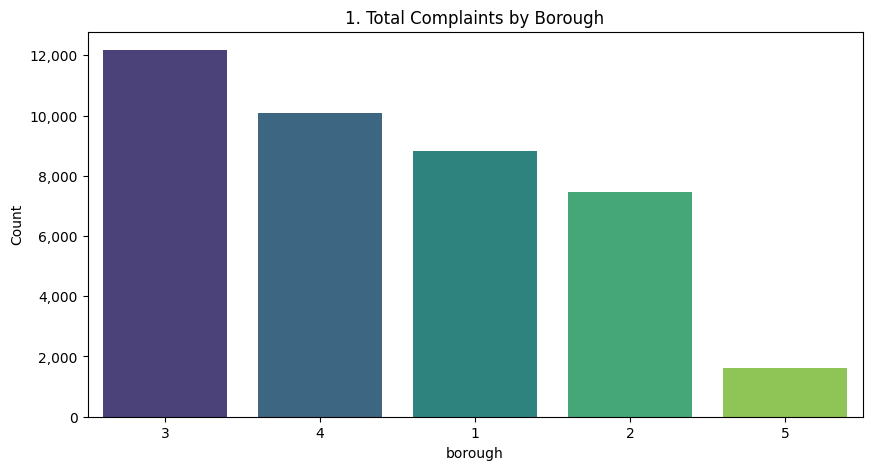

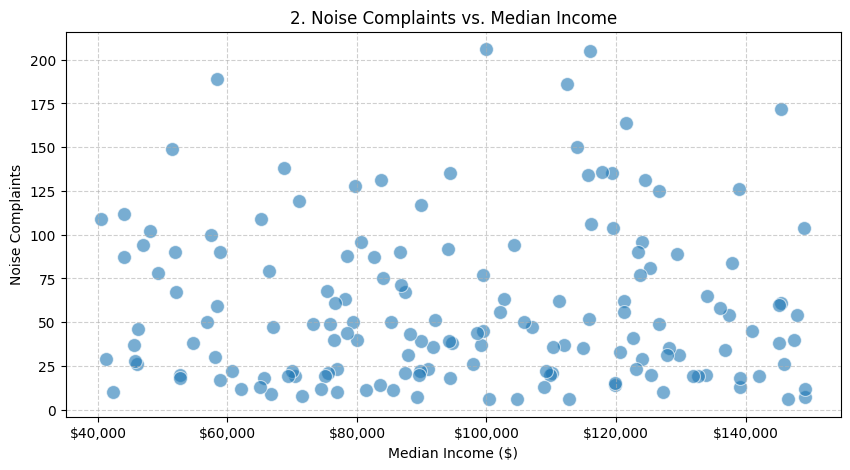


--- Insight 3: Top 10 Most Expensive Zip Codes ---
  zip_code     avg_price  sales_volume
0    10001 12,458,058.17           408
1    10004  9,721,584.78           190
2    10005  9,156,857.75           398
3    10018  7,023,968.95           168
4    10013  5,117,624.53          1366
5    10007  4,254,656.30           626
6    10006  3,848,211.41           368
7    10010  3,371,599.16           918
8    10011  3,061,715.66          2096
9    10012  2,983,154.63           574


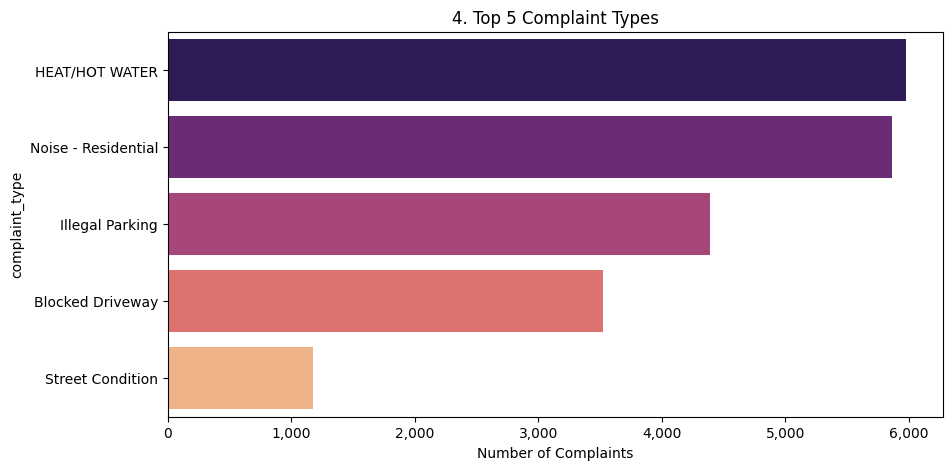

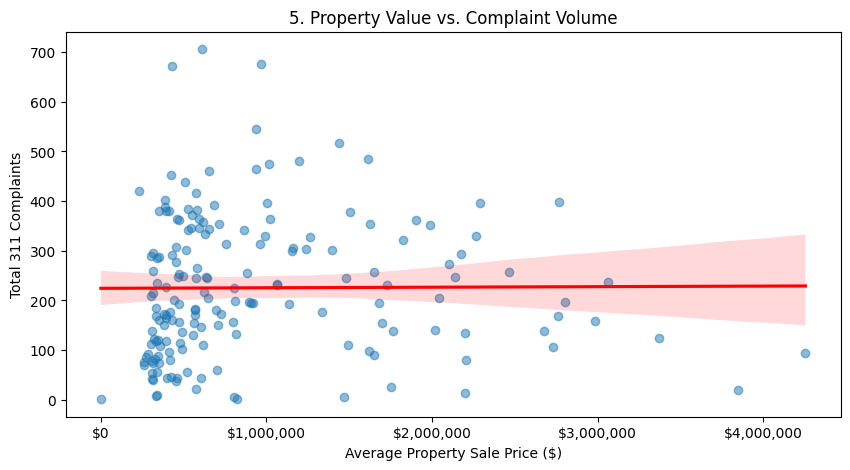

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import psycopg2
from google.colab import userdata
import warnings

# --- CONFIGURATION ---
warnings.filterwarnings('ignore') # Silence SQLAlchemy warnings
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x)) # Format tables with commas (e.g. 1,000.00)

# Setup connection
try:
    CONN_STRING = userdata.get('NEON_DB_CONNECTION_STRING')
    conn = psycopg2.connect(CONN_STRING)
except Exception as e:
    print(f"Connection error: {e}")

print("--- GENERATING ANALYSIS PART 1 (Formatted) ---")

# ===================================================================
# QUERY 1: Complaint Volume by Borough
# ===================================================================
sql_q1 = """
SELECT
    d.borough,
    COUNT(r.unique_key) as total_complaints
FROM dim_nyc_demographics d
JOIN fact_311_requests r ON d.zip_code = r.incident_zip
GROUP BY d.borough
ORDER BY total_complaints DESC;
"""
df_q1 = pd.read_sql(sql_q1, conn)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_q1, x='borough', y='total_complaints', hue='borough', palette='viridis', legend=False)
plt.title('1. Total Complaints by Borough')
plt.ylabel('Count')
# Fix Y-axis to show full numbers (no scientific notation)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


# ===================================================================
# QUERY 2: The "Rich vs. Loud" Correlation
# ===================================================================
sql_q2 = """
SELECT
    d.zip_code,
    d.median_income,
    COUNT(r.unique_key) as noise_complaints
FROM dim_nyc_demographics d
JOIN fact_311_requests r ON d.zip_code = r.incident_zip
WHERE r.complaint_type ILIKE '%Noise%'
GROUP BY d.zip_code, d.median_income
HAVING COUNT(r.unique_key) > 5
ORDER BY d.median_income DESC;
"""
df_q2 = pd.read_sql(sql_q2, conn)

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_q2, x='median_income', y='noise_complaints', alpha=0.6, s=100)
plt.title('2. Noise Complaints vs. Median Income')
plt.xlabel('Median Income ($)')
plt.ylabel('Noise Complaints')
plt.grid(True, linestyle='--', alpha=0.6)
# Fix X-axis to show dollars
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.show()


# ===================================================================
# QUERY 3: High-Value Real Estate Activity
# ===================================================================
sql_q3 = """
SELECT
    zip_code,
    AVG(sale_price) as avg_price,
    COUNT(sale_id) as sales_volume
FROM fact_property_sales
GROUP BY zip_code
HAVING COUNT(sale_id) > 5
ORDER BY avg_price DESC
LIMIT 10;
"""
df_q3 = pd.read_sql(sql_q3, conn)

print("\n--- Insight 3: Top 10 Most Expensive Zip Codes ---")
# This will now print with commas thanks to the pd.set_option above
print(df_q3)


# ===================================================================
# QUERY 4: Complaint Types Breakdown
# ===================================================================
sql_q4 = """
SELECT
    complaint_type,
    COUNT(*) as count
FROM fact_311_requests
GROUP BY complaint_type
ORDER BY count DESC
LIMIT 5;
"""
df_q4 = pd.read_sql(sql_q4, conn)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_q4, y='complaint_type', x='count', hue='complaint_type', palette='magma', legend=False)
plt.title('4. Top 5 Complaint Types')
plt.xlabel('Number of Complaints')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


# ===================================================================
# QUERY 5: Sales vs. Complaints Correlation
# ===================================================================
sql_q5 = """
WITH ComplaintCounts AS (
    SELECT incident_zip, COUNT(*) as c_count
    FROM fact_311_requests
    GROUP BY incident_zip
),
SalesAvg AS (
    SELECT zip_code, AVG(sale_price) as avg_price
    FROM fact_property_sales
    GROUP BY zip_code
)
SELECT
    s.zip_code,
    s.avg_price,
    c.c_count as complaint_volume
FROM SalesAvg s
JOIN ComplaintCounts c ON s.zip_code = c.incident_zip
WHERE s.avg_price > 0 AND s.avg_price < 5000000;
"""
df_q5 = pd.read_sql(sql_q5, conn)

plt.figure(figsize=(10, 5))
sns.regplot(data=df_q5, x='avg_price', y='complaint_volume', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('5. Property Value vs. Complaint Volume')
plt.xlabel('Average Property Sale Price ($)')
plt.ylabel('Total 311 Complaints')
# Fix X-axis to show dollars
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.show()

# Clean up connection
conn.close()

--- GENERATING ANALYSIS PART 2 (RETRY) ---

--- Insight 6: Top 3 Wealthiest Zip Codes per Borough ---
   borough zip_code  median_income  income_rank
0        1    10024     148,962.00            1
1        1    10004     144,982.00            2
2        1    10167     143,822.00            3
3        2    10474     146,618.00            1
4        2    10459     145,525.00            2
5        2    10452     145,418.00            3
6        3    11229     147,948.00            1
7        3    11235     147,532.00            2
8        3    11224     145,882.00            3
9        4    11414     149,148.00            1
10       4    11363     143,012.00            2
11       4    11367     142,129.00            3
12       5    10302     149,246.00            1
13       5    10309     116,706.00            2
14       5    10304      97,915.00            3

--- Insight 7: Count of 'High Value' Zips with Rodent Problems: 128 ---
  zip_code
0    11203
1    11415
2    11412
3    11216
4 

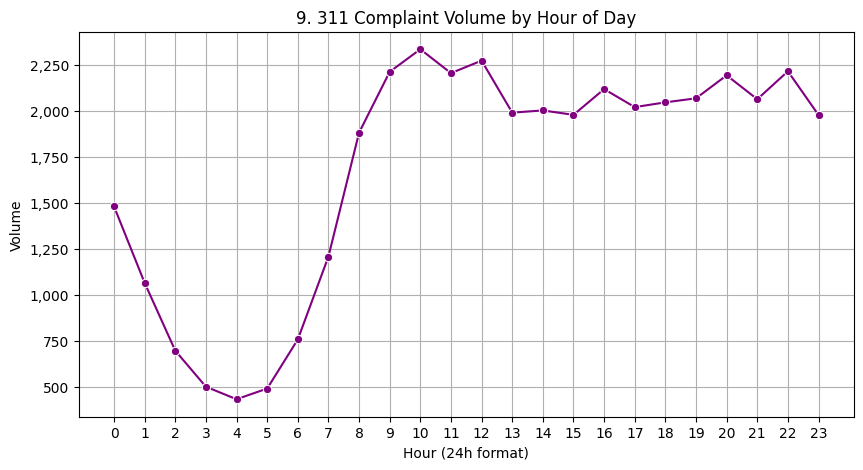

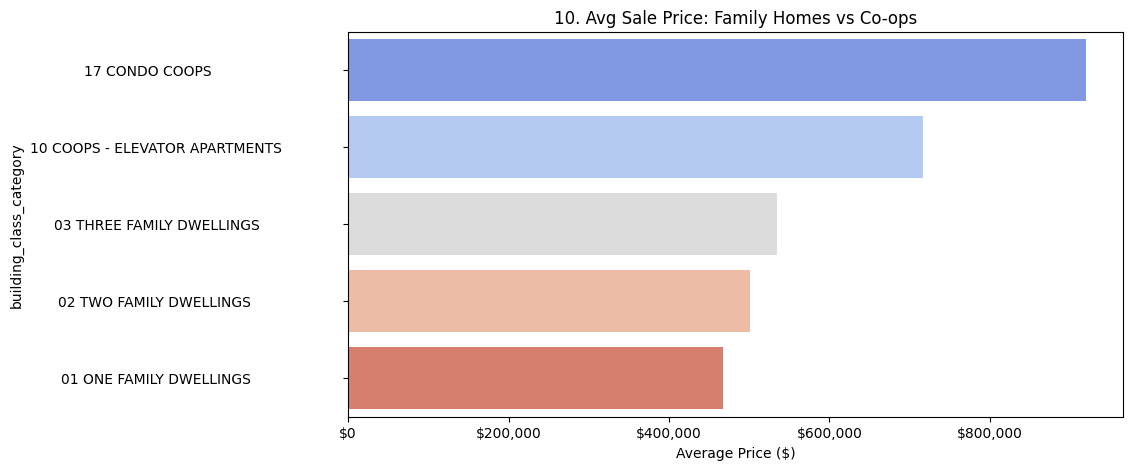

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import psycopg2
from google.colab import userdata
import warnings

# --- CONFIGURATION ---
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# Setup connection
try:
    CONN_STRING = userdata.get('NEON_DB_CONNECTION_STRING')
    conn = psycopg2.connect(CONN_STRING)
except Exception as e:
    print(f"Connection error: {e}")

print("--- GENERATING ANALYSIS PART 2 (RETRY) ---")

# ===================================================================
# QUERY 6: Ranking Zip Codes by Income within Boroughs
# ===================================================================
sql_q6 = """
WITH RankedZips AS (
    SELECT
        borough,
        zip_code,
        median_income,
        RANK() OVER (PARTITION BY borough ORDER BY median_income DESC) as income_rank
    FROM dim_nyc_demographics
    WHERE median_income > 0
)
SELECT * FROM RankedZips
WHERE income_rank <= 3;
"""
df_q6 = pd.read_sql(sql_q6, conn)

print("\n--- Insight 6: Top 3 Wealthiest Zip Codes per Borough ---")
print(df_q6)


# ===================================================================
# QUERY 7: The "Rodent" vs. "High Value" Paradox
# ===================================================================
sql_q7 = """
SELECT DISTINCT zip_code
FROM fact_property_sales
WHERE sale_price > 1000000
AND zip_code IN (
    SELECT incident_zip
    FROM fact_311_requests
    WHERE complaint_type ILIKE '%Rodent%'
);
"""
df_q7 = pd.read_sql(sql_q7, conn)

print(f"\n--- Insight 7: Count of 'High Value' Zips with Rodent Problems: {len(df_q7)} ---")
print(df_q7.head(10))


# ===================================================================
# QUERY 8: Analyzing a View
# ===================================================================
sql_q8 = """
SELECT
    zip_code,
    borough,
    median_income,
    avg_sale_price
FROM view_zip_wealth_summary
WHERE median_income > 80000
  AND avg_sale_price < 600000
ORDER BY median_income DESC;
"""
df_q8 = pd.read_sql(sql_q8, conn)

print("\n--- Insight 8: Potential Undervalued Markets (High Income / Low Property Cost) ---")
print(df_q8.head())


# ===================================================================
# QUERY 9: Complaints by Hour of Day
# ===================================================================
sql_q9 = """
SELECT
    EXTRACT(HOUR FROM created_date) as hour_of_day,
    COUNT(*) as complaint_count
FROM fact_311_requests
GROUP BY hour_of_day
ORDER BY hour_of_day;
"""
df_q9 = pd.read_sql(sql_q9, conn)

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_q9, x='hour_of_day', y='complaint_count', marker='o', color='purple')
plt.title('9. 311 Complaint Volume by Hour of Day')
plt.xlabel('Hour (24h format)')
plt.ylabel('Volume')
plt.grid(True)
plt.xticks(range(0, 24))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


# ===================================================================
# QUERY 10: Comparison of Building Classes
# ===================================================================
sql_q10 = """
SELECT
    building_class_category,
    AVG(sale_price) as avg_price,
    COUNT(*) as sales_count
FROM fact_property_sales
WHERE building_class_category ILIKE '%FAMILY%'
   OR building_class_category ILIKE '%COOPS%'
GROUP BY building_class_category
HAVING COUNT(*) > 10
ORDER BY avg_price DESC
LIMIT 5;
"""
df_q10 = pd.read_sql(sql_q10, conn)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_q10, y='building_class_category', x='avg_price', palette='coolwarm')
plt.title('10. Avg Sale Price: Family Homes vs Co-ops')
plt.xlabel('Average Price ($)')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.show()

conn.close()